В этом ноутбуке берется переписанный код статьи и проверяется корректность его запуска, а именно, что итоговые метрики будут похожи на предоставленные в статье.

In [1]:
%cd ..

/workspace/TabDDPM_copy/TabDDPM


/venv/main/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils import *
from models.tabddpm.tabddpm import *

### Подготовка

In [3]:
model_name = 'tabddpm'
dataname = 'magic'
model_short = 'TabDDPM'
save_cat = 1

In [4]:
CONFIG.add_arg('dataname', dataname)
CONFIG.add_arg('method', model_name)
CONFIG.add_arg('save_cat', save_cat)

In [5]:
download_dataset(dataname)
process_data(dataname)

Start processing dataset magic from UCI.
Aready downloaded.
n_clusters: 25
magic (17118, 11) (1902, 11) (19020, 11)


/workspace/TabDDPM_copy/TabDDPM/utils.py:373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns = idx_name_mapping, inplace=True)
/workspace/TabDDPM_copy/TabDDPM/utils.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns = idx_name_mapping, inplace=True)
/workspace/TabDDPM_copy/TabDDPM/utils.py:412: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

Numerical (17118, 10)
Categorical (17118, 0)
Processing and Saving magic Successfully!
magic
Total 19020
Train 17118
Test 1902
Num 10
Cat 1


In [6]:
if torch.cuda.is_available():
    device = f'cuda'
else:
    device = 'cpu'
CONFIG.add_arg('device', device)
print(f"Device: {device}")


CONFIG.add_arg('sample_save_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/{CONFIG.get_arg('method')}.csv")
CONFIG.add_arg('real_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/real.csv")
CONFIG.add_arg('test_path',
               f"synthetic/{CONFIG.get_arg('dataname')}/test.csv")
CONFIG.add_arg('info_path',
               f"data/{CONFIG.get_arg('dataname')}/info.json")

Device: cuda


In [7]:
CONFIG.get_all_args()

{'dataname': 'magic',
 'method': 'tabddpm',
 'device': 'cuda',
 'mode': 'train',
 'train': 1,
 'sample_save_path': 'synthetic/magic/tabddpm.csv',
 'sigma_scheduller_name': 'constant',
 'sigma_value': 0.001,
 'num_noise': 78,
 'real_path': 'synthetic/magic/real.csv',
 'test_path': 'synthetic/magic/test.csv',
 'info_path': 'data/magic/info.json',
 'save_path': './synthetic/default_ON_QnSC_200k/initial_tabddpm_ON_QnSC_200k_mult_9.csv',
 'num_clusters': 25,
 'save_cat': 1}

### Train

In [8]:
CONFIG.add_arg('mode', 'train')

In [9]:
tabddpm = TabDDPM(CONFIG)

In [ ]:
tabddpm.train()

START TRAINING
No NaNs in numerical features, skipping
12
{'num_classes': 2, 'is_y_cond': False, 'rtdl_params': {'d_layers': [1024, 2048, 2048, 1024], 'dropout': 0.0}, 'd_in': 12}
mlp
MLPDiffusion(
  (mlp): MLP(
    (blocks): ModuleList(
      (0): Block(
        (linear): Linear(in_features=1024, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (1): Block(
        (linear): Linear(in_features=1024, out_features=2048, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (2): Block(
        (linear): Linear(in_features=2048, out_features=2048, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (3): Block(
        (linear): Linear(in_features=2048, out_features=1024, bias=True)
        (activation): ReLU()
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (head): Linear(in_features=1024, out_feature

In [11]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
    
cmap = get_cmap(10)

/tmp/ipykernel_79523/2983808042.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  return plt.cm.get_cmap(name, n)


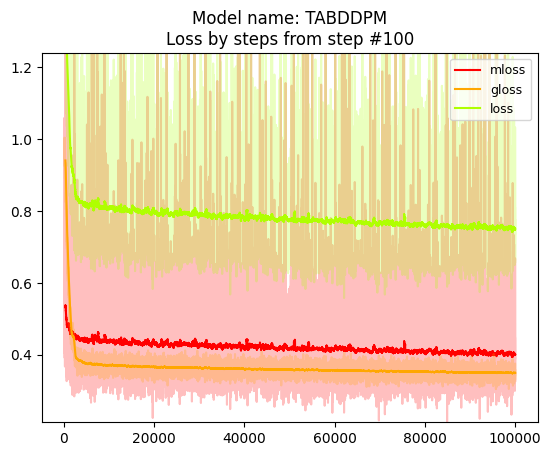

In [12]:
loss = pd.read_csv(f'./models/{model_name}/ckpt/{dataname}/loss.csv')
max_v, min_v = -np.inf, np.inf
window = 250

start_step = 100
for i, l in enumerate(loss.columns[1:]):
    plt.plot(loss['step'][start_step:], loss[l][start_step:], alpha=0.25, color=cmap(i))
    smoothed = np.convolve(loss[l][start_step:], np.ones(window)/window, 'valid')  
    plt.plot(loss['step'][start_step+window-1:], smoothed, label=l, color=cmap(i))

    max_v = np.max([np.quantile(loss[l][start_step:], 0.99), max_v])
    min_v = np.min([np.quantile(loss[l][start_step:], 0.01), min_v])

plt.ylim([min_v-0.1, max_v+0.1]) 
plt.legend()
plt.title(f"Model name: {model_name.upper()}\nLoss by steps from step #{start_step}")
plt.savefig(f'./models/{model_name}/ckpt/{dataname}/loss_image.png')
plt.show()

In [13]:
tabddpm.sample(sample_save_path=CONFIG.get_arg('sample_save_path'))

No NaNs in numerical features, skipping
mlp
torch.Size([10000, 2])
Sample timestep    0
torch.Size([10000, 2])
Sample timestep    0
Shape torch.Size([17118, 11])
(17118, 1)
Sampling time: 96.60687565803528


### Расчет метрик

In [14]:
from eval.base_metrics import calculate_base_metrics
from eval.similarity import calculate_similarity
from eval.mle import calculate_mle
from eval.alpha_beta import calculate_alpha_beta
from eval.detection import calculate_detection
from eval.dcr import calculate_DCR

In [15]:
overall_metrics = {}
overall_metrics[model_name] = {}

#### Метрики из starter_kit

In [16]:
overall_metrics[model_name]['base_metrics'] = calculate_base_metrics(make_binary=False)

TABDDPM: MAGIC Dataset
Original Logistic: 0.833
Synthetic Logistic: 0.833
Original Tree: 0.872
Synthetic Tree: 0.871 

TABDDPM Accuracy Loss: MAGIC
Logistic: 0.058%
Tree: 0.075% 



#### Метрики из статьи TabSyn

In [17]:
overall_metrics[model_name]['similarity'] = calculate_similarity()

CALCULATING COLUMN-WISE DENSITY ESTIMATION & PAIR-WISE COLUMN CORRELATION...
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 11/11 [00:00<00:00, 118.53it/s]|
Column Shapes Score: 98.91%

(2/2) Evaluating Column Pair Trends: |██████████| 55/55 [00:00<00:00, 91.52it/s]|
Column Pair Trends Score: 98.88%

Overall Score (Average): 98.9%

Error rate (%) of column-wise density estimation TABDDPM: 1.090 ± 0.374
Error rate (%) of pair-wise column correlation score TABDDPM: 1.116 ± 1.122


DONE! 

DRAW COLUMN VALUES DISTRIBUTIONS...


DONE!


#### MLE

In [18]:
overall_metrics[model_name]['mle'] = calculate_mle()

100%|██████████| 36/36 [00:06<00:00,  5.55it/s]


Saving scores to  eval/mle/magic/tabddpm.json
ROC - AUC обучения на синтетических данных TABDDPM: 0.924 ± 0.006


#### Detection: classifier two sample tests (C2ST)

In [19]:
overall_metrics[model_name]['detection'] = calculate_detection()

magic, tabddpm: 0.985271036974872


#### DCR

In [20]:
overall_metrics[model_name]['DCR'] = calculate_DCR()

n_clusters: 25
DCR Score, a value closer to 0.5 is better
magic-tabddpm, DCR Score = 0.5120341161350626


#### Alpha precision & Beta recall

In [21]:
overall_metrics[model_name]['quality'] = calculate_alpha_beta()

=========== All Features ===========
Data shape:  (17118, 12)
alpha precision: 0.978676, beta recall: 0.491915


### Табличка

In [22]:
final_metrics_table = []
for m in overall_metrics.keys():
    # Сбор таблички результатов
    tmp = pd.DataFrame([{'Model':'TabDDPM', 'Type':m, 'Data':dataname}])
    tmp.columns = pd.MultiIndex.from_tuples([('', i) for i in tmp.columns])
    result = [tmp]
    
    for metric_group in overall_metrics[m].keys():
        tmp = pd.DataFrame([overall_metrics[m][metric_group]])
        tmp.columns = pd.MultiIndex.from_tuples([(metric_group, i) for i in tmp.columns])
        result.append(tmp)
    result = pd.concat(result, axis = 1)
    final_metrics_table.append(result)
    
final_metrics_table = pd.concat(final_metrics_table)

In [23]:
pd.set_option('display.max_columns', None)
final_metrics_table.round(4)

base_metrics                                   \
     Model     Type   Data Original Logistic Synthetic Logistic Original Tree   
0  TabDDPM  tabddpm  magic            0.8331             0.8326        0.8719   

                                                                  \
  Synthetic Tree Accuracy Loss Logistic, % Accuracy Loss Tree, %   
0         0.8712                    0.0582                0.0753   

              similarity                              \
  Column Shapes Score, % Column Pair Trends Score, %   
0                98.9102                     98.8844   

                              \
  Overall Score (Average), %   
0                    98.8973   

                                                       \
  Error rate (%) of column-wise density estimation, %   
0                                              1.0898   

                                                           \
  Error rate (%) of column-wise density estimation std, %   
0                                                  0.3743   

                                                           \
  Error rate (%) of pair-wise column correlation score, %   
0                                                  1.1156   

                                                               \
  Error rate (%) of pair-wise column correlation score std, %   
0                                                      1.1218   

                                         mle  \
  ROC - AUC обучения на синтетических данных   
0                                     0.9241   

                                                  detection    DCR  \
  ROC - AUC обучения на синтетических данных, std     Score  Score   
0                                          0.0058    0.9853  0.512   

          quality              
  alpha precision beta recall  
0          0.9787      0.4919

In [24]:
import os
if not os.path.exists(f'./eval/total/{dataname}'):
    os.makedirs(f'./eval/total/{dataname}')
final_metrics_table.to_csv(f'./eval/total/{dataname}/{model_short}_final_metrics_table.csv', index=False)